In [26]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import pymysql.cursors
import glob

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import sklearn.linear_model as lm
from sklearn import dummy, metrics
from sklearn.model_selection import train_test_split

import seaborn as sns
%matplotlib inline

# Import, Clean and Prepare Dataset

#### Read in data, clean column names,  date columns to datetime, order cleaning

In [25]:
# Bring in the data
#adobe = pd.read_csv('data/wel/machine_learning/ML_DATA_CPA_1.csv')
l = [pd.read_csv(filename) for filename in glob.glob("data/raw_data/*.csv")]
adobe = pd.concat(l, axis=0)

# Clean up column names
adobe.columns = ['Date', 'Adobe ID', 'Eloqua ID', 'Order ID', 'Tracking Code', 'Internal Campaign', 
        'Eloqua Campaign ID', 'Full Page URL', 'Country', 'Browser Type', 'Mobile Device Type', 
        'Referring Domain', 'Product', 'Lead Gen Signup Page', 'Lead Gen Product', 'Product Suite', 
        'Lead Gen Signup', 'Cart: Billing', 'Cart: Login', 'Cart: Payment', 'Cart: My Cart',
        'Free Trial Signup Date', 'Purchase Date']

# Date column formatting
adobe.Date = pd.to_datetime(adobe.Date, format='%B %d, %Y', exact=False)
for col in ['Free Trial Signup Date', 'Purchase Date']:
    adobe[col] = adobe[col].astype(str).str.rstrip('.0')
    adobe[col] = pd.to_datetime(adobe[col], errors='coerce')
    
# Clean up data
adobe = adobe.dropna(subset=['Adobe ID'])

# Order Stuff
adobe['Product'] = adobe['Product'].fillna('')
adobe['Orders'] = adobe.Product.str.contains('PLATINUM|GOLD|SILVER').astype(int)
adobe['Orders'] = adobe['Orders'].replace(0, np.nan)
adobe.loc[~adobe.Product.str.contains('PLATINUM|GOLD|SILVER'), 'Purchase Date'] = pd.NaT

#### Sort by ID, Fill in all rows within ID groups with signup date, purchase date, and whether someone ordered

In [10]:
# Sort by ID then Date
adobe = adobe.sort_values(['Adobe ID', 'Date'])

# Fill in Signup dates for each user on every row
adobe['Free Trial Signup Date'] = adobe.groupby('Adobe ID')['Free Trial Signup Date'].ffill()
adobe['Free Trial Signup Date'] = adobe.groupby('Adobe ID')['Free Trial Signup Date'].bfill()

# Fill in Purchase Dates for each user on every row, THEN drop data that occurs after someone purchases
adobe['Purchase Date'] = adobe.groupby('Adobe ID')['Purchase Date'].ffill()
adobe['Purchase Date'] = adobe.groupby('Adobe ID')['Purchase Date'].bfill()

# Fill in Purchase Dates for each user on every row, THEN drop data that occurs after someone purchases
adobe['Orders'] = adobe.groupby('Adobe ID')['Orders'].ffill()
adobe['Orders'] = adobe.groupby('Adobe ID')['Orders'].bfill()

#### Add Page View Columns, app views, campaign code cleanup, referrer, source, browser, country, signups

In [11]:
# Various Page View Columns
adobe['Free Trial Views'] = adobe['Full Page URL'].str.contains('free-trial', na=0).astype(int)
adobe['App Views'] = adobe['Full Page URL'].str.contains('app.', na=0).astype(int)
adobe['CPA Views'] = adobe['Full Page URL'].str.contains('cpa/', na=0).astype(int)

# Split Tracking Code into new columns and concat
split_df = adobe['Tracking Code'].str.split('|', expand=True)
split_df.drop(5, axis=1, inplace=True)
split_df.columns = ['Campaign Medium', 'Campaign Source', 'Campaign Content', 'Campaign Term', 'Campaign Campaign']
adobe = pd.concat([adobe, split_df], axis=1)

# Split Internal Campaign into new columns and concat
split_df = adobe['Internal Campaign'].str.split('|', expand=True)
split_df.drop([0, 5], axis=1, inplace=True)
split_df.columns = ['IC Campaign', 'IC Product', 'IC Date', 'IC Offer']
adobe = pd.concat([adobe, split_df], axis=1)

# Clean up Referring Domain column
adobe['Referring Domain'] = adobe['Referring Domain'].str.lower().fillna('NONE')
adobe.loc[adobe['Referring Domain'].str.contains('google'), 'Referring Domain'] = 'google'
adobe.loc[adobe['Referring Domain'].str.contains('facebook'), 'Referring Domain'] = 'facebook'
adobe.loc[adobe['Referring Domain'].str.contains('bing'), 'Referring Domain'] = 'bing'
adobe.loc[adobe['Referring Domain'].str.contains('yahoo'), 'Referring Domain'] = 'yahoo'
adobe.loc[adobe['Referring Domain'].str.contains('wiley'), 'Referring Domain'] = 'wiley'
adobe.loc[adobe['Referring Domain'].str.contains('t.co|twitter'), 'Referring Domain'] = 'twitter'

# Clean up Campaign Source column
adobe['Campaign Source'] = adobe['Campaign Source'].str.lower().fillna('NONE')
adobe.loc[adobe['Campaign Source'].str.contains('google'), 'Campaign Source'] = 'google'
adobe.loc[adobe['Campaign Source'].str.contains('facebook'), 'Campaign Source'] = 'facebook'
adobe.loc[adobe['Campaign Source'].str.contains('bing'), 'Campaign Source'] = 'bing'
adobe.loc[adobe['Campaign Source'].str.contains('yahoo'), 'Campaign Source'] = 'yahoo'
adobe.loc[adobe['Campaign Source'].str.contains('wiley'), 'Campaign Source'] = 'wiley'
adobe.loc[adobe['Campaign Source'].str.contains('t.co|twitter'), 'Campaign Source'] = 'twitter'

# Clean up Campaign Medium column
adobe['Campaign Medium'] = adobe['Campaign Medium'].str.lower().fillna('NONE')
adobe.loc[adobe['Campaign Medium'].str.contains('social|facebook'), 'Campaign Medium'] = 'social'
adobe.loc[adobe['Campaign Medium'].str.contains('email'), 'Campaign Medium'] = 'email'
adobe.loc[adobe['Campaign Medium'].str.contains('search|display|cpc|retarget|banner'), 'Campaign Medium'] = 'adwords'
adobe.loc[adobe['Campaign Medium'].str.contains('paid|chat|website|pdf|sms|other|page'), 'Campaign Medium'] = 'Other'
adobe.loc[adobe['Campaign Medium'] == '', 'Campaign Medium'] = 'NONE'

# Clean up IC Campaign column
adobe['IC Campaign'] = adobe['IC Campaign'].str.lower().fillna('NONE')
adobe.loc[adobe['IC Campaign'].str.contains('om_ftacquisition_cpa'), 'IC Campaign'] = 'cpa_acquisition'
adobe.loc[adobe['IC Campaign'].str.contains('freetrial_cpa_newusers_all'), 'IC Campaign'] = 'cpa_conversion'
adobe.loc[adobe['IC Campaign'].str.contains('purch|cfa|cma'), 'IC Campaign'] = 'Other'
adobe.loc[adobe['IC Campaign'] == '', 'IC Campaign'] = 'NONE'

# Clean up Country column
countries = ['united states', 'india', 'saudi arabia', 'united arab emirates', 'canada', 'japan']
adobe.loc[~adobe['Country'].isin(countries), 'Country'] = 'other'

# Campaign Touches
#adobe['Campaign Touches'] = (adobe['Campaign Campaign'].notnull()).astype(int)
#adobe['Internal Campaign Touches'] = (adobe['IC Campaign'].notnull()).astype(int)

# CPA Free Trial Signup Page
adobe['CPA Free Trial Signups'] = ((adobe['Lead Gen Signup Page'].str.contains('Try the Wiley CPAexcel CPA Review')) 
                                    & (adobe['Lead Gen Signup'] > 0)).astype(int)

In [12]:
# GET DUMMIES
country_dummies = pd.get_dummies(adobe['Country'], prefix='Country')
campaign_dummies = pd.get_dummies(adobe['Campaign Medium'], prefix='Campaign')
IC_dummies = pd.get_dummies(adobe['IC Campaign'], prefix='IC')
adobe = pd.concat([adobe, country_dummies, campaign_dummies, IC_dummies], axis=1) 

#Remove all data that occurs after someone purchases the product
#adobe = adobe[(adobe['Date'] < adobe['Purchase Date']) | (adobe['Purchase Date'].isnull())]

# Add a column for days since free trial signup
adobe['Days_since_trial'] = [i.days for i in (adobe['Free Trial Signup Date'] - adobe['Date'])]

# Actions after FT Signup
adobe['FT App Views'] = ((adobe['Days_since_trial'] >= 0) & (adobe['App Views'] == 1)).astype(int)
adobe['App Views'] = adobe['App Views'] - adobe['FT App Views']
adobe['FT CPA Views'] = ((adobe['Days_since_trial'] >= 0) & (adobe['CPA Views'] == 1)).astype(int)
adobe['CPA Views'] = adobe['CPA Views'] - adobe['FT CPA Views']

In [13]:
ADOBE = adobe.drop(['Eloqua ID', 'Order ID', 'Eloqua Campaign ID', 'Browser Type', 'Mobile Device Type', 
                    'Lead Gen Product', 'Lead Gen Signup Page', 'Campaign Medium', 
                    'Campaign Source', 'Campaign Content', 'Campaign Campaign', 'IC Campaign', 'IC Product', 
                    'IC Date', 'IC Offer', 'Full Page URL', 'Tracking Code', 'Internal Campaign', 
                    'Campaign Term', 'Referring Domain', 'Product Suite', 'Country', 'Days_since_trial', 
                    'Campaign_NONE', 'IC_NONE'], axis=1)

ADOBE = ADOBE.groupby('Adobe ID').sum()
ADOBE = ADOBE[ADOBE['CPA Free Trial Signups'] > 0]
ADOBE['Orders'] = ADOBE['Orders'].fillna(0)
ADOBE = ADOBE[ADOBE['CPA Views'] < 110]

dummy_cols = (country_dummies.columns.tolist() + ['Orders'])
for col in dummy_cols:
    ADOBE.loc[ADOBE[col] > 0, col] = 1
    
#ADOBE.to_csv('data/final_dataset.csv')

# Analysis

In [8]:
ADOBE = pd.read_csv('data/final_dataset.csv', index_col='Adobe ID')
ADOBE.head()

,Lead Gen Signup,Cart: Billing,Cart: Login,Cart: Payment,Cart: My Cart,Orders,Free Trial Views,App Views,CPA Views,CPA Free Trial Signups,Country_canada,Country_india,Country_japan,Country_other,Country_saudi arabia,Country_united arab emirates,Country_united states,Campaign_Other,Campaign_adwords,Campaign_email,Campaign_partner,Campaign_reminder,Campaign_seo,Campaign_social,Campaign_wiley,IC_Other,IC_cpa_acquisition,IC_cpa_conversion,IC_offer,IC_offercomp,IC_starterguide,FT App Views,FT CPA Views
Adobe ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00005345086593070040291327536242798320,1,0,0,0,0,0.0,2,7,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3
00013418822727405491225776334975654930,1,0,0,0,0,0.0,2,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
00017502700076701111954157062983352095,1,0,0,0,0,0.0,2,0,4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
00020055984285579200624053006867516624,1,0,0,0,0,0.0,2,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
00021817023889049544050306274275301087,1,0,0,0,0,0.0,2,0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2,4


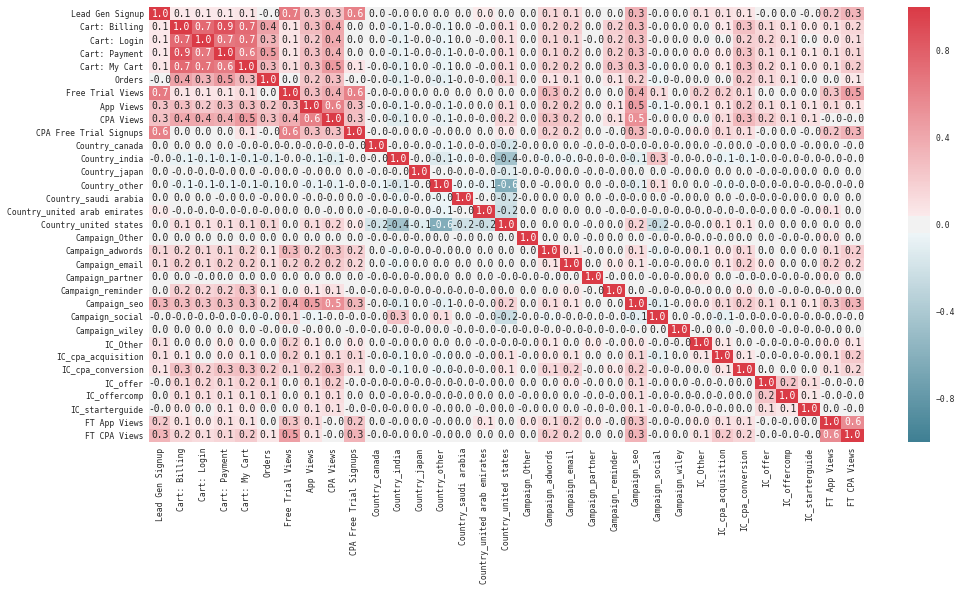

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
sns.set(context="paper", font="monospace")

cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = ADOBE.corr()
# print correlations
sns.heatmap(correlations, cmap=cmap, annot=True, fmt='.1f')
plt.gcf().set_size_inches(16, 8);

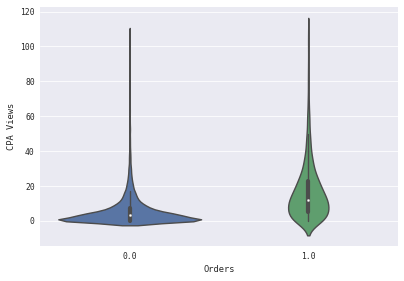

In [10]:
sns.violinplot(x='Orders', y='CPA Views', data=ADOBE);

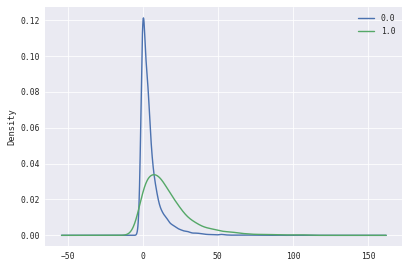

In [11]:
ADOBE.groupby('Orders')['CPA Views'].plot(kind='kde', legend=True);

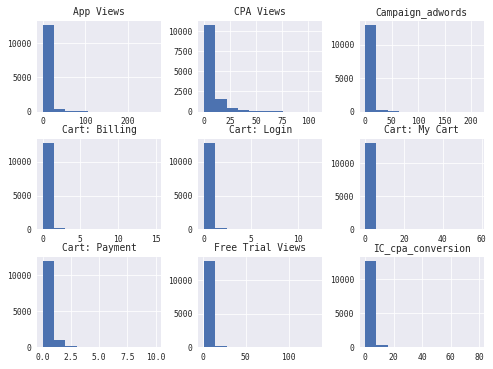

In [12]:
ADOBE.hist(column=['App Views', 'CPA Views', 'Campaign_adwords', 'Cart: Billing', 'IC_cpa_conversion',
                  'Cart: Login', 'Cart: My Cart', 'Cart: Payment', 'Free Trial Views'], figsize=(8,6));

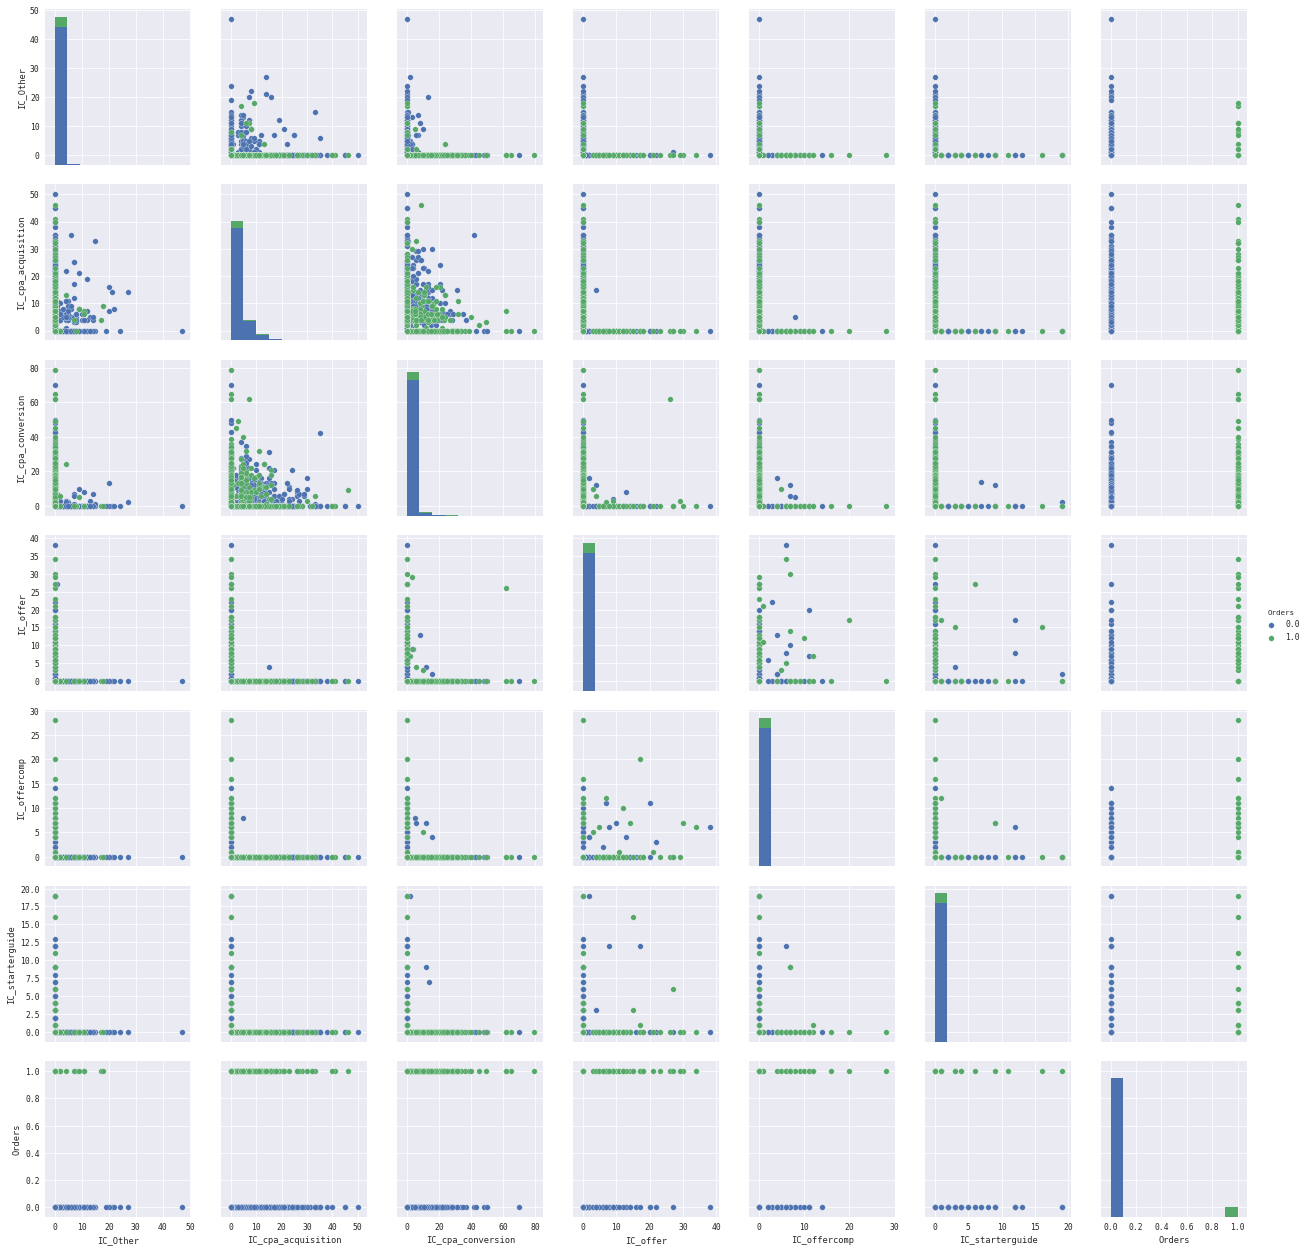

In [13]:
select_cols = ['Cart: Billing', 'App Views', 'CPA Views', 'Campaign Touches',
                   'Internal Campaign Touches', 'CPA Free Trial Signups']
campaign_cols = [col for col in ADOBE.columns if 'Campaign_' in col] + ['Orders']
IC_cols = [col for col in ADOBE.columns if 'IC_' in col] + ['Orders']

sns.pairplot(data=ADOBE, 
             vars=IC_cols, 
             hue="Orders");

### Visualizing AUC Performance Against Baseline

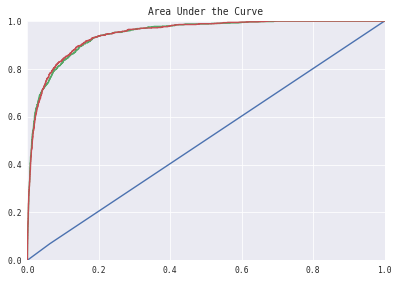

In [14]:
from sklearn import dummy, metrics
import sklearn.linear_model as lm

X = ADOBE.drop(['Orders'], axis=1)
y = ADOBE['Orders']

model0 = dummy.DummyClassifier()
model0.fit(X, y)
X['probability_0'] = model0.predict_proba(X).T[1]

model1 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=18, max_features=3, 
                               bootstrap=False, min_samples_split=28, criterion='entropy', class_weight='balanced')
model1.fit(X, y)
X['probability_1'] = model1.predict_proba(X).T[1]

model2 = lm.LogisticRegression()
model2.fit(X, y)
X['probability_2'] = model2.predict_proba(X).T[1]

ax = plt.subplot(111)
vals = metrics.roc_curve(y, X.probability_0)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(y, X.probability_1)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(y, X.probability_2)
ax.plot(vals[0], vals[1])


ax.set(title='Area Under the Curve', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1));

# Logistic Regression Approach

In [27]:
ADOBE = pd.read_csv('data/final_dataset.csv', index_col='Adobe ID')

# Normalize Data
min_max_scaler = preprocessing.MinMaxScaler()
ADOBE = pd.DataFrame(min_max_scaler.fit_transform(ADOBE), columns=ADOBE.columns, index=ADOBE.index)

In [28]:
X = ADOBE.drop(['Orders'], axis=1)
y = ADOBE['Orders']

# Split the data into 15% test and 85% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

model = lm.LogisticRegression()
model.fit(X_train, y_train)
scores = cross_val_score(model, X_test, y_test, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean().round(4)))

CV AUC [ 0.88253751  0.89098402  0.84377136], Average AUC 0.8724


# Random Forest Approach

In [29]:
ADOBE = pd.read_csv('data/final_dataset.csv', index_col='Adobe ID')

# Normalize Data
min_max_scaler = preprocessing.MinMaxScaler()
ADOBE = pd.DataFrame(min_max_scaler.fit_transform(ADOBE), columns=ADOBE.columns, index=ADOBE.index)

In [32]:
X = ADOBE.drop(['Orders'], axis=1)
y = ADOBE['Orders']

# Split the data into 15% test and 85% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=18, max_features=3, 
                               bootstrap=False, min_samples_split=28, criterion='entropy', class_weight='balanced')
model.fit(X_train, y_train)
scores = cross_val_score(model, X_test, y_test, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean().round(4)))

CV AUC [ 0.91337308  0.89842741  0.90715457], Average AUC 0.9063


In [33]:
predicted = model.predict(X_test)
compare = pd.DataFrame([predicted, y_test]).transpose()
compare.columns = ['Predicted', 'Actual']

TP = ((compare['Predicted'] == 1) & (compare['Actual'] == 1)).sum()
FP = ((compare['Predicted'] == 1) & (compare['Actual'] == 0)).sum()
TN = ((compare['Predicted'] == 0) & (compare['Actual'] == 0)).sum()
FN = ((compare['Predicted'] == 0) & (compare['Actual'] == 1)).sum()

accuracy = (TP + TN) / (X_test.shape[0])
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print(accuracy, precision, recall)

0.904580152672 0.397928994083 0.743093922652


In [34]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df['Importance Score'] = features_df['Importance Score'].round(5)
features_df

,Features,Importance Score
1,Cart: Billing,0.20892
3,Cart: Payment,0.18305
4,Cart: My Cart,0.18224
7,CPA Views,0.07855
2,Cart: Login,0.07169
15,Country_united states,0.04903
6,App Views,0.04720
21,Campaign_seo,0.03016
31,FT CPA Views,0.02836
26,IC_cpa_conversion,0.01966
